In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
#from torch import cuda
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cuda' if cuda.is_available() else 'cpu'
#device
print(f"working on {device}")
# Check the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

working on cuda
Number of GPUs available: 1


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    RobertaTokenizer,
    RobertaModel,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm

In [6]:
file_paths = [
    '../data/anger_frustration.csv',
    '../data/confusion_sorrow_boredom.csv',
    '../data/disgust_surprise_alarm_fear.csv',
    '../data/interest_desire.csv',
    '../data/joy_hope.csv',
    '../data/understanding_gratitude_relief.csv'
]


In [7]:
import os
import pandas as pd
general_labels = {
    'anger_frustration.csv': 'anger_frustration',
    'confusion_sorrow_boredom.csv': 'confusion_sorrow_boredom',
    'disgust_surprise_alarm_fear.csv': 'disgust_surprise_alarm_fear',
    'interest_desire.csv': 'interest_desire',
    'joy_hope.csv': 'joy_hope',
    'understanding_gratitude_relief.csv': 'understanding_gratitude_relief'
}

# Function to extract the general label from the file path
def extract_general_label(file_path):
    file_name = os.path.basename(file_path)
    return general_labels.get(file_name, 'unknown')

# Load CSV files into DataFrames and add general labels
dataframes = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    general_label = extract_general_label(file_path)
    df['Emotions'] = general_label  # Set the general label for all rows
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
data

,Emotions,Behavior ID,Description,All,NumIndexes
0,anger_frustration,anger000,"Say ""No!"" > Display Face2 > Drive forward quic...","('say_text', 'No!', 1, 0)\r\n('display_oled_fa...",6.0
1,anger_frustration,anger001,"Say ""Oon!"" > Turn 30deg quickly > Raise arms h...","('say_text', 'Oon!', 1, 0)\r\n('turn_in_place'...",5.0
2,anger_frustration,anger002,"Display Face2 > Say ""Gurr!"" > Lift arms quickl...","('display_oled_face_image', 'resources/cozmo_f...",9.0
3,anger_frustration,anger003,Raise head > Lift arms quickly > Turn 30deg qu...,"('set_head_angle', 45, 1)\r\n('set_lift_height...",7.0
4,anger_frustration,anger004,Raise arms halfway > Display Face2 > Drive lon...,"('set_lift_height', 0.5, 0.2)\r\n('display_ole...",6.0
...,...,...,...,...,...
1035,understanding_gratitude_relief,understanding177,NaN,NaN,NaN
1036,understanding_gratitude_relief,understanding178,NaN,NaN,NaN
1037,understanding_gratitude_relief,understanding179,NaN,NaN,NaN
1038,understanding_gratitude_relief,understanding180,NaN,NaN,NaN


In [8]:
#Handles missing value for the "All" column
data.dropna(subset=["All"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
import re

def process_text(actions_str):
    # Regex pattern to match the tuples in your string
    pattern = r"\(([^)]+)\)"
    
    # Find all tuples in the string
    matches = re.findall(pattern, actions_str)
    
    result = []
    for match in matches:
        # Split each tuple's content by commas, remove extra spaces
        elements = [elem.strip() for elem in match.split(",")]
        
        # Rebuild the action string, converting numbers and removing quotes
        action = elements[0].strip("'")  # Get the action name
        args = [arg.strip("'") if "'" in arg else arg for arg in elements[1:]]  # Process arguments
        action_str = "_".join([action] + args)
        
        # Special case: Remove file path in display_oled_face_image
        if action == 'display_oled_face_image':
            face_identifier = args[0].split('/')[-1].replace('.png', '')
            action_str = f"display_oled_face_image_{face_identifier}_{args[1]}"
        
        # Remove all special characters
        #action_str = re.sub(r'[^a-zA-Z0-9_]', '', action_str)
        
        result.append(action_str)
    
    # Join all the action strings with a space
    return " ".join(result)


In [10]:
data['Behaviors'] = data['All'].apply(process_text)

In [11]:
# Count the occurrences of each emotion label
emotion_counts = data['Emotions'].value_counts()
print("Emotion label distribution:\n", emotion_counts)


Emotion label distribution:
 Emotions
disgust_surprise_alarm_fear       159
confusion_sorrow_boredom          123
anger_frustration                  84
joy_hope                           84
interest_desire                    78
understanding_gratitude_relief     68
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Emotion_Label'] = label_encoder.fit_transform(data['Emotions'])
data

,Emotions,Behavior ID,Description,All,NumIndexes,Behaviors,Emotion_Label
0,anger_frustration,anger000,"Say ""No!"" > Display Face2 > Drive forward quic...","('say_text', 'No!', 1, 0)\r\n('display_oled_fa...",6.0,say_text_No!_1_0 display_oled_face_image_face2...,0
1,anger_frustration,anger001,"Say ""Oon!"" > Turn 30deg quickly > Raise arms h...","('say_text', 'Oon!', 1, 0)\r\n('turn_in_place'...",5.0,say_text_Oon!_1_0 turn_in_place_30_230 set_lif...,0
2,anger_frustration,anger002,"Display Face2 > Say ""Gurr!"" > Lift arms quickl...","('display_oled_face_image', 'resources/cozmo_f...",9.0,display_oled_face_image_face2_1 say_text_Gurr!...,0
3,anger_frustration,anger003,Raise head > Lift arms quickly > Turn 30deg qu...,"('set_head_angle', 45, 1)\r\n('set_lift_height...",7.0,set_head_angle_45_1 set_lift_height_1_0.2 turn...,0
4,anger_frustration,anger004,Raise arms halfway > Display Face2 > Drive lon...,"('set_lift_height', 0.5, 0.2)\r\n('display_ole...",6.0,set_lift_height_0.5_0.2 display_oled_face_imag...,0
...,...,...,...,...,...,...,...
591,understanding_gratitude_relief,understanding051,Turn 30deg > Display Face8 > Lower head > Lift...,"('turn_in_place', 30, 100)\r\n('display_oled_f...",9.0,turn_in_place_30_100 display_oled_face_image_f...,5
592,understanding_gratitude_relief,understanding052,Turn -30deg > Display Face4 > Lower head > Lif...,"('turn_in_place', -30, 100)\r\n('display_oled_...",8.0,turn_in_place_-30_100 display_oled_face_image_...,5
593,understanding_gratitude_relief,understanding054,Display Face8 > Display Face9 > Lower head > D...,"('display_oled_face_image', 'resources/cozmo_f...",10.0,display_oled_face_image_face8_1 display_oled_f...,5
594,understanding_gratitude_relief,understanding055,Lift arms halfway quickly > Display Face7 > Sa...,"('set_lift_height', 0.5, 0.2)\r\n('display_ole...",8.0,set_lift_height_0.5_0.2 display_oled_face_imag...,5


In [13]:
# Assuming 'data' is your DataFrame
data.to_csv('research_data.csv', index=False)

In [14]:

num_class=len(data['Emotions'].unique())

print("Total number of emotions labels :",num_class)

Total number of emotions labels : 6


In [15]:
from sklearn.preprocessing import LabelEncoder

# Prepare the text and labels
texts = data['Behaviors'].tolist()
# Encode labels using LabelEncoder
labels = data['Emotions'].tolist()
X_train, X_test_dev, y_train, y_test_dev = train_test_split(texts, labels, stratify = labels, test_size=0.2, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X_test_dev, y_test_dev,stratify = y_test_dev, test_size=0.5, random_state=42)

In [16]:
X_test

['display_oled_face_image_face7_1 display_oled_face_image_face6_1 say_text_oh_1_0 display_oled_face_image_face6_1 set_head_angle_-30_1 set_lift_height_0.75_0.2 display_oled_face_image_face6_1 say_text_boo hoo!_1_1',
 'turn_in_place_-30_500 display_oled_face_image_face8_1 display_oled_face_image_face9_0.2 display_oled_face_image_face8_0.5 say_text_ah!_1_1 turn_in_place_30_500 display_oled_face_image_face12_1',
 'turn_in_place_30_500 display_oled_face_image_face15_1 say_text_gah!_1_0 turn_in_place_-30_500 display_oled_face_image_face15_1 say_text_gurr!_1_1 display_oled_face_image_face2_1 turn_in_place_30_500 display_oled_face_image_face15_1',
 'drive_straight_200_50 display_oled_face_image_face6_1 say_text_boo hoo_1_0 set_head_angle_-30_1 display_oled_face_image_face6_1',
 'set_head_angle_45_1 display_oled_face_image_face8_1 say_text_Uh huh_1_1 set_lift_height_1_0.2 set_lift_height_0_1 say_text_Okie!_1_1 display_oled_face_image_face8_1',
 'say_text_Huhh?_1_1 set_head_angle_20_1 display_o

In [17]:
y_test

['confusion_sorrow_boredom',
 'interest_desire',
 'anger_frustration',
 'confusion_sorrow_boredom',
 'understanding_gratitude_relief',
 'confusion_sorrow_boredom',
 'understanding_gratitude_relief',
 'joy_hope',
 'confusion_sorrow_boredom',
 'disgust_surprise_alarm_fear',
 'confusion_sorrow_boredom',
 'anger_frustration',
 'joy_hope',
 'interest_desire',
 'interest_desire',
 'disgust_surprise_alarm_fear',
 'confusion_sorrow_boredom',
 'anger_frustration',
 'disgust_surprise_alarm_fear',
 'understanding_gratitude_relief',
 'disgust_surprise_alarm_fear',
 'confusion_sorrow_boredom',
 'disgust_surprise_alarm_fear',
 'disgust_surprise_alarm_fear',
 'disgust_surprise_alarm_fear',
 'understanding_gratitude_relief',
 'interest_desire',
 'anger_frustration',
 'disgust_surprise_alarm_fear',
 'confusion_sorrow_boredom',
 'confusion_sorrow_boredom',
 'anger_frustration',
 'disgust_surprise_alarm_fear',
 'confusion_sorrow_boredom',
 'interest_desire',
 'joy_hope',
 'confusion_sorrow_boredom',
 'co

In [23]:
training_distribution = pd.Series(y_train).value_counts()
print("Emotion label distribution in training data:\n", training_distribution)


Emotion label distribution in training data:
 disgust_surprise_alarm_fear       127
confusion_sorrow_boredom           98
anger_frustration                  67
joy_hope                           67
interest_desire                    62
understanding_gratitude_relief     55
Name: count, dtype: int64


In [24]:
#data.to_csv('original_data.csv', index=False)

In [25]:
class EMRODataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_len):
        self.behaviors = [self.preprocess_text(t) for t in text]
        
        self.labels = labels  # Emotion labels as indices
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.behaviors)

    def __getitem__(self, idx):
        behavior = self.behaviors[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            behavior,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
        'input_ids': inputs['input_ids'].squeeze(0),  # Shape: [seq_length]
        'attention_mask': inputs['attention_mask'].squeeze(0),  # Shape: [seq_length]
        'targets': torch.tensor(label, dtype=torch.long)  # integer Emotion label as tensor
    }
        
    def preprocess_text(self,text):
      text = text.replace("-", " "). replace("_", " ")
      return text


In [26]:
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup

class RobertaClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(RobertaClass, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.roberta.config.hidden_size, num_classes)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.last_hidden_state[:, 0] 
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits  # Return loss and logits for training
        else:
            return logits

In [27]:
emotions = data['Emotions'].unique()
emotion_to_label = {emotion: idx for idx, emotion in enumerate(emotions)}
label_to_emotion = {idx: emotion for emotion, idx in emotion_to_label.items()}
emro_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [28]:
emotion_to_label

{'anger_frustration': 0,
 'confusion_sorrow_boredom': 1,
 'disgust_surprise_alarm_fear': 2,
 'interest_desire': 3,
 'joy_hope': 4,
 'understanding_gratitude_relief': 5}

In [20]:
# Data loaders
max_len = 128
batch_size = 8
emro_train_dataset = EMRODataset(X_train, [emotion_to_label[e] for e in y_train], emro_tokenizer, max_len)
emro_val_dataset = EMRODataset(X_dev, [emotion_to_label[e] for e in y_dev], emro_tokenizer, max_len)
emro_train_loader = DataLoader(emro_train_dataset, batch_size=batch_size, shuffle=True)
emro_val_loader = DataLoader(emro_val_dataset, batch_size=batch_size, shuffle=False)


In [21]:

num_class=len(data['Emotions'].unique())
print("Total number of emotions labels :",num_class)

NUM_OUT = num_class
emro_model = RobertaClass(NUM_OUT)
emro_model.to(device)

Total number of emotions labels : 6


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [24]:
def train_emro_model(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training EMRO"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)

        optimizer.zero_grad()
        loss, logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss


In [25]:
def evaluate_emro_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating EMRO"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)

            loss, logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels  # Provide labels to compute loss
            )
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    average_loss = total_loss / len(dataloader)
    return average_loss, accuracy


In [26]:
# Optimizer for EMRO
emro_optimizer = torch.optim.AdamW(emro_model.parameters(), lr=2e-5)
best_val_loss = float('inf')
patience = 2  # Number of epochs to wait before stopping
counter = 0
# Number of epochs
emro_epochs = 8


In [26]:
for epoch in range(emro_epochs):
    print(f"EMRO Epoch {epoch + 1}/{emro_epochs}")
    train_loss = train_emro_model(emro_model, emro_train_loader, emro_optimizer, device)
    val_loss, val_accuracy = evaluate_emro_model(emro_model, emro_val_loader, device)
    print(f"EMRO Training Loss: {train_loss:.4f}")
    print(f"EMRO Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the model
        #torch.save(emro_model.state_dict(), 'best_emro_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Save the trained EMRO model
#torch.save(emro_model.state_dict(), 'emro_model.pt')


EMRO Epoch 1/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s]


EMRO Training Loss: 1.7756
EMRO Validation Loss: 1.7284, Accuracy: 0.3333
EMRO Epoch 2/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.53it/s]


EMRO Training Loss: 1.3726
EMRO Validation Loss: 0.8812, Accuracy: 0.6833
EMRO Epoch 3/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s]


EMRO Training Loss: 0.8011
EMRO Validation Loss: 0.5092, Accuracy: 0.8833
EMRO Epoch 4/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.52it/s]


EMRO Training Loss: 0.5216
EMRO Validation Loss: 0.4579, Accuracy: 0.8333
EMRO Epoch 5/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.45it/s]


EMRO Training Loss: 0.3316
EMRO Validation Loss: 0.3756, Accuracy: 0.9000
EMRO Epoch 6/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s]


EMRO Training Loss: 0.2954
EMRO Validation Loss: 0.4800, Accuracy: 0.8500
EMRO Epoch 7/8


Evaluating EMRO: 100%|██████████| 4/4 [00:00<00:00, 15.54it/s]

EMRO Training Loss: 0.2139
EMRO Validation Loss: 0.4697, Accuracy: 0.8833
Early stopping triggered


In [22]:
emro_model.load_state_dict(torch.load('best_emro_model.pt'))
emro_model.to(device)
emro_model.eval()

/tmp/ipykernel_25632/3438546974.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emro_model.load_state_dict(torch.load('best_emro_model.pt'))


RobertaClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [27]:
# After training is complete
emro_test_dataset = EMRODataset(X_test, [emotion_to_label[e] for e in y_test], emro_tokenizer, max_len)
emro_test_loader = DataLoader(emro_test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate_emro_model(emro_model, emro_test_loader, device)
print(f"EMRO Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")


Evaluating EMRO: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

EMRO Test Loss: 0.2392, Accuracy: 0.9333


100%|██████████| 8/8 [00:00<00:00, 26.86it/s]


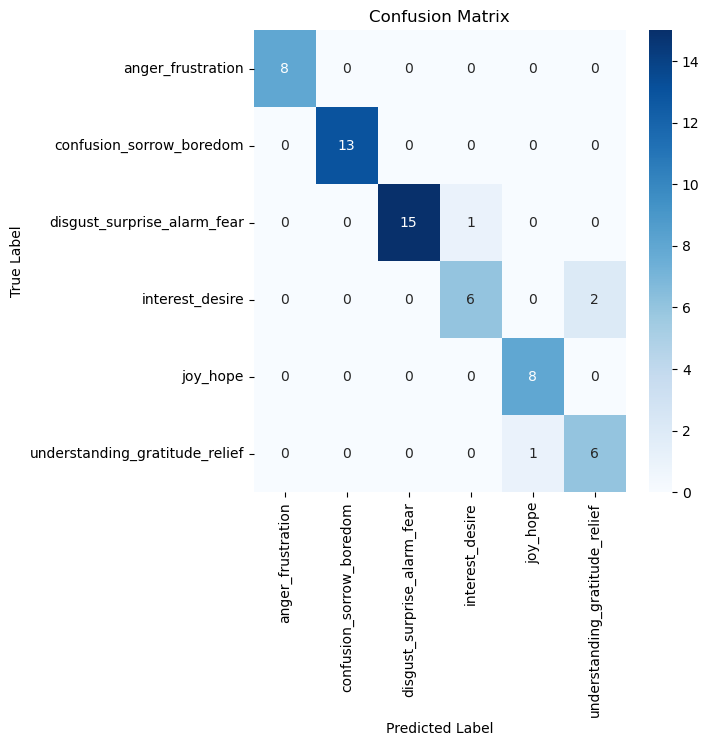

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
true_labels = []
predicted_labels = []
with torch.no_grad():
    for batch in tqdm(emro_test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)
        _, logits = emro_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        predictions = torch.argmax(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_to_label.keys(), yticklabels=emotion_to_label.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


**For GRED Model**

In [35]:
import gc
torch.cuda.empty_cache()
#del model
gc.collect()

418

In [36]:
class GREDDataset(Dataset):
    def __init__(self, emotions, behaviors, tokenizer, max_len, emotion_to_label):
        self.emotions = emotions
        self.behaviors = behaviors
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotion_to_label = emotion_to_label

    def __len__(self):
        return len(self.emotions)

    def __getitem__(self, idx):
        emotion = self.emotions[idx]
        behavior = self.behaviors[idx]

        # Create the prompt
        prompt = f"<|startoftext|>Emotion: {emotion} <|endoftext|> Behaviors:"
        target = f"{behavior} <|endoftext|>"
        full_input = prompt + " " + target
        
        # Tokenize the full input
        inputs = self.tokenizer(
            full_input,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze()  # Shape: (seq_len,)
        attention_mask = inputs['attention_mask'].squeeze()
        
        labels = input_ids.clone()
        labels[:len(self.tokenizer(prompt)['input_ids'])] = -100 
        emotion_label = torch.tensor(self.emotion_to_label[emotion], dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'emotion_label': emotion_label  # Integer emotion label
        }

In [37]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

gred_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-medium")
gred_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-medium")

In [38]:
# Add a padding token and resize token embeddings
special_tokens_dict = {'additional_special_tokens': ['<|startoftext|>', '<|endoftext|>']}
gred_tokenizer.add_special_tokens(special_tokens_dict)
if gred_tokenizer.pad_token is None:
    gred_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

gred_model.resize_token_embeddings(len(gred_tokenizer))
gred_model.to(device)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50259, bias=False)
)

In [39]:
def train_gred(gred_model, dataloader, optimizer, device):
    gred_model.train()
    total_loss = 0.0
    for batch in dataloader:
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        emotion_labels = batch['emotion_label'].to(device)  # Original emotion label for GRED
        # Reset gradients
        optimizer.zero_grad()
        outputs = gred_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Track total loss
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    return average_loss


In [40]:
def evaluate_gred(gred_model, dataloader, device):
    gred_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            emotion_labels = batch['emotion_label'].to(device)
    
            # Forward pass through GRED model with EMRO feedback
            outputs = gred_model(input_ids, attention_mask=attention_mask, labels = labels)
            loss = outputs.loss
            total_loss += loss.item()
    
    average_loss = total_loss / len(dataloader)
    return average_loss

In [41]:
gred_train_dataset = GREDDataset(y_train, X_train, gred_tokenizer, max_len, emotion_to_label)
gred_val_dataset = GREDDataset(y_dev, X_dev, gred_tokenizer, max_len, emotion_to_label)
gred_test_dataset = GREDDataset(y_test, X_test, gred_tokenizer, max_len, emotion_to_label)
train_batch_size = 8
val_batch_size =16

gred_train_loader = DataLoader(gred_train_dataset, batch_size=train_batch_size, shuffle=True)
gred_val_loader = DataLoader(gred_val_dataset, batch_size=val_batch_size, shuffle=False)
gred_test_loader = DataLoader(gred_test_dataset, batch_size=val_batch_size, shuffle=False)


In [42]:
gred_optimizer = torch.optim.AdamW(gred_model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [49]:
best_val_loss = float('inf')
patience = 2  # Number of epochs to wait before stopping
counter = 0
EPOCHS = 18
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Training Phase
    train_loss = train_gred(
        gred_model, gred_train_loader, gred_optimizer, device
    )
    print(f"Training Loss: {train_loss:.4f} ")
    
    val_loss= evaluate_gred(
        gred_model, gred_val_loader, device
    )
    print(f"Validation Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the model  
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/18
Training Loss: 3.3940 
Validation Loss: 2.4562

Epoch 2/18
Training Loss: 1.9311 
Validation Loss: 1.0602

Epoch 3/18
Training Loss: 0.6476 
Validation Loss: 0.3788

Epoch 4/18
Training Loss: 0.3607 
Validation Loss: 0.3526

Epoch 5/18
Training Loss: 0.3323 
Validation Loss: 0.3328

Epoch 6/18
Training Loss: 0.3118 
Validation Loss: 0.3229

Epoch 7/18
Training Loss: 0.3002 
Validation Loss: 0.3240

Epoch 8/18
Training Loss: 0.2890 
Validation Loss: 0.3186

Epoch 9/18
Training Loss: 0.2807 
Validation Loss: 0.3181

Epoch 10/18
Training Loss: 0.2737 
Validation Loss: 0.3195

Epoch 11/18
Training Loss: 0.2623 
Validation Loss: 0.3155

Epoch 12/18
Training Loss: 0.2541 
Validation Loss: 0.3225

Epoch 13/18
Training Loss: 0.2501 
Validation Loss: 0.3259
Early stopping triggered


In [43]:
gred_model.load_state_dict(torch.load('best_gred_model.pt', weights_only=True))
gred_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50259, bias=False)
)

In [37]:
def create_prompt(emotion):
    prompt = f"<|startoftext|>Emotion: {emotion} <|endoftext|> Behaviors:"
    return prompt

In [39]:
def generate_behavior(gred_model, gred_tokenizer, emotion, num_samples=2, max_length=256):
    behaviors = []
    gred_model.eval()
    prompt = create_prompt(emotion)

    input_ids = gred_tokenizer.encode(
        prompt, 
        return_tensors='pt', 
        max_length=max_length, 
        truncation=True
    ).to(device)
    
    for _ in range(num_samples):
        with torch.no_grad():
            output_sequences = gred_model.generate(
                input_ids=input_ids,
                max_length=max_length,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                pad_token_id=gred_tokenizer.pad_token_id
            )
        generated_text = gred_tokenizer.decode(output_sequences[0], skip_special_tokens=True)
        #print("generated text is ", generated_text)
        # Remove the prompt from the generated text
        behavior = generated_text.split(":")[-1].strip()
        behaviors.append(behavior)
    
    return behaviors

In [40]:
# Generate behaviors for each emotion
def generate_behaviors_for_emotions(gred_model, gred_tokenizer, emotions, num_samples=20, num_runs=10):
    all_generated_behaviors = []
    emotions_list = []
    behaviors_list = []

    for _ in range(num_runs):  # Repeat the process for 10 runs
        for emotion in emotions:
            generated_behaviors = generate_behavior(
                gred_model=gred_model,
                gred_tokenizer=gred_tokenizer,
                emotion=emotion,
                num_samples=num_samples
            )

            for behavior in generated_behaviors:
                emotions_list.append(emotion)
                behaviors_list.append(behavior)
                #print(f"{emotion}: {behavior}")
                all_generated_behaviors.append((emotion, behavior))

    return all_generated_behaviors, emotions_list, behaviors_list


In [41]:
all_generated_behaviors, emotions_list, behaviors_list = generate_behaviors_for_emotions(
    gred_model=gred_model,
    gred_tokenizer=gred_tokenizer,
    emotions=emotions,
    num_samples=20,  # Behaviors per run
    num_runs=5  # Total runs
)

In [46]:
#df = pd.DataFrame({"Emotion": emotions_list, "Behavior": behaviors_list})
#df.to_csv("gred_data.csv", index=False)

In [50]:
# Load CSV
#df = pd.read_csv("gred_data.csv")

# Convert into list of tuples (emotion, behavior)
#all_generated_behaviors = [(row["Emotion"], row["Behavior"]) for _, row in df.iterrows()]
# Extract behaviors and emotions as lists
#behaviors_list = df["Behavior"].tolist()
#emotions_list = df["Emotion"].tolist()


**Evaluating using EMRO model**

In [51]:
test_dataset = EMRODataset(behaviors_list, [emotion_to_label[e] for e in emotions_list], emro_tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
# After training is complete
test_loss, test_accuracy = evaluate_emro_model(emro_model, test_loader, device)
print(f"EMRO Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

Evaluating EMRO: 100%|██████████| 75/75 [00:02<00:00, 26.23it/s]

EMRO Test Loss: 0.3009, Accuracy: 0.8950


**Getting novelty scores for the behvaiors generated without any loss**

In [41]:
class EmbeddingsExtractor(torch.nn.Module):
    def __init__(self, emro_model, tokenizer, device):
        super().__init__()
        self.emro_model = emro_model
        self.tokenizer = tokenizer
        self.device = device
        for param in self.emro_model.parameters():
            param.requires_grad = False
        self.emro_model.eval()

    def get_embedding(self, text):
        if isinstance(text, str):
            text = [text]
        inputs = self.tokenizer(
            text, return_tensors='pt',  max_length=128, truncation=True, padding=True
        ).to(self.device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = self.emro_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        # Usually take the [CLS] token (first token) as the pooled embedding
        pooled_output = last_hidden_state[:, 0, :]
    
        return pooled_output

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def compute_cosine_similarity_for_emotion(embeddings, emotion_labels, emotion):
    # Extract indices of behaviors with the given emotion
    emotion_indices = [i for i, label in enumerate(emotion_labels) if label == emotion]
    emotion_embeddings = [embeddings[i] for i in emotion_indices]  # Extract embeddings for this emotion

    # Ensure the embeddings are moved to CPU before calculating cosine similarity
    emotion_embeddings_cpu = [embedding.cpu().numpy() for embedding in emotion_embeddings]
    
    # Compute the cosine similarity matrix for the emotion embeddings
    cosine_sim_matrix = cosine_similarity(emotion_embeddings_cpu)
    
    # Get the upper triangular indices to compute pairwise similarity for unique pairs
    upper_triangular_indices = np.triu_indices(len(emotion_embeddings_cpu), k=1)
    similarity_values = cosine_sim_matrix[upper_triangular_indices]

    # Calculate the average cosine similarity
    avg_cosine_similarity = np.mean(similarity_values) if similarity_values.size > 0 else 1.0

    return avg_cosine_similarity

# Calculate novelty for each emotion
def compute_average_novelty_by_emotion(embeddings, emotion_labels):
    avg_novelty_by_emotion = {}
    
    # Loop through each emotion and compute average cosine similarity and novelty
    emotions = set(emotion_labels)  # Get unique emotions
    for emotion in emotions:
        avg_cosine_similarity = compute_cosine_similarity_for_emotion(embeddings, emotion_labels, emotion)
        #novelty_scores = torch.stack([torch.exp(-cs) for cs in avg_cosine_sims])
        avg_novelty_score = 1 - avg_cosine_similarity  # Novelty is inversely related to similarity
        avg_novelty_by_emotion[emotion] = np.float32(avg_novelty_score)  # Store novelty as float32
    
    return avg_novelty_by_emotion

def evaluate_novelty(all_generated_behaviors, embeddings_extractor):
    behaviors = [behavior for _, behavior in all_generated_behaviors]
    emotion_labels = [emotion for emotion, _ in all_generated_behaviors]

    # Extract embeddings for all behaviors using the embeddings extractor
    behavior_embeddings = embeddings_extractor.get_embedding(behaviors)

    # Compute average novelty score by emotion
    avg_novelty_by_emotion = compute_average_novelty_by_emotion(behavior_embeddings, emotion_labels)

    # Print or return the novelty scores
    print("Novelty Scores for each emotions")
    for emotion, novelty_score in avg_novelty_by_emotion.items():
        print(f"{emotion}:: {novelty_score}")

    return avg_novelty_by_emotion


In [54]:
embeddings_extractor = EmbeddingsExtractor(emro_model, emro_tokenizer, device)
avg_novelty_by_emotion = evaluate_novelty(all_generated_behaviors, embeddings_extractor)

Novelty Scores for each emotions
interest_desire:: 0.36489301919937134
anger_frustration:: 0.06581497192382812
disgust_surprise_alarm_fear:: 0.29562056064605713
confusion_sorrow_boredom:: 0.37712782621383667
joy_hope:: 0.1551913619041443
understanding_gratitude_relief:: 0.25257617235183716


**Novelty scores for original behaviors**

In [49]:
original_embeddings = embeddings_extractor.get_embedding(texts)
original_novelty_by_emotion = compute_average_novelty_by_emotion(original_embeddings, labels)

print("Original Novelty Scores:")
for emotion, novelty_score in original_novelty_by_emotion.items():
    print(f"{emotion}: {novelty_score}")

Original Novelty Scores:
confusion_sorrow_boredom: 0.39123237133026123
disgust_surprise_alarm_fear: 0.28924643993377686
joy_hope: 0.31836092472076416
anger_frustration: 0.20455330610275269
interest_desire: 0.36509305238723755
understanding_gratitude_relief: 0.44749927520751953


**GRED with EMRO**

In [34]:
gred_model.load_state_dict(torch.load('best_gred_model.pt', weights_only=True))
gred_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50259, bias=False)
)

In [41]:
# Combined Model
class GREDwithEMRO(nn.Module):
    def __init__(self, gred_model, gred_tokenizer, emro_model, emro_tokenizer, emotion_to_label, max_len=128):
        super(GREDwithEMRO, self).__init__()
        self.gred_model = gred_model
        self.gred_tokenizer = gred_tokenizer
        self.emro_model = emro_model
        self.emro_tokenizer = emro_tokenizer
        self.emro_model.eval()
        for param in self.emro_model.parameters():
            param.requires_grad = False
        self.gred_model.config.output_hidden_states = True

        self.projection = nn.Sequential(
            nn.Linear(self.gred_model.config.hidden_size, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU()
        )

        self.emro_loss_fn = nn.CrossEntropyLoss()
        self.emotion_to_label = emotion_to_label

    def forward(self, input_ids, attention_mask, labels, emotion_label):
        gred_outputs = self.gred_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        gred_loss = gred_outputs.loss
        hidden_states = gred_outputs.hidden_states[-1]
        projected_embeddings = self.projection(hidden_states).mean(dim=1)
        emro_logits = self.emro_model.classifier(self.emro_model.dropout(projected_embeddings))
        emro_loss = self.emro_loss_fn(emro_logits, emotion_label)
        total_loss = gred_loss + emro_loss
        return total_loss, gred_loss, emro_loss

# Training and Evaluation Functions
def train_gred_with_emro_feedback(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_gred_loss = 0.0
    total_emro_loss = 0.0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        emotion_labels = batch['emotion_label'].to(device)
        optimizer.zero_grad()
        total_batch_loss, gred_loss, emro_loss = model(input_ids, attention_mask, labels, emotion_labels)
        
        total_batch_loss.backward()
        optimizer.step()
        total_loss += total_batch_loss.item()
        total_gred_loss += gred_loss.item()
        total_emro_loss += emro_loss.item()
        
    average_total_loss = total_loss / len(dataloader)
    average_gred_loss = total_gred_loss / len(dataloader)
    average_emro_loss = total_emro_loss / len(dataloader)
    
    return average_total_loss,average_gred_loss, average_emro_loss

# Data Preparation and Training Loop
gred_train_dataset = GREDDataset(y_train, X_train, gred_tokenizer, max_len, emotion_to_label)
gred_train_loader = DataLoader(gred_train_dataset, batch_size=8, shuffle=True)

gred_model_name = GREDwithEMRO(gred_model, gred_tokenizer, emro_model, emro_tokenizer, emotion_to_label).to(device)
gred_optimizer = torch.optim.AdamW(
    list(gred_model_name.gred_model.parameters()) + list(gred_model_name.projection.parameters()), 
    lr=1e-5
)


In [45]:
EPOCHS= 18
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss, train_gred_loss, train_emro_loss = train_gred_with_emro_feedback(gred_model_name, gred_train_loader, gred_optimizer, device)
    print(f"Training Loss: {train_loss:.4f} | GRED Loss: {train_gred_loss:.4f} | EMRO Loss: {train_emro_loss:.4f}")


Epoch 1/18
Training Loss: 2.4023 | GRED Loss: 0.2676 | EMRO Loss: 1.7789

Epoch 2/18
Training Loss: 1.4920 | GRED Loss: 0.3180 | EMRO Loss: 0.9784

Epoch 3/18
Training Loss: 0.6337 | GRED Loss: 0.3304 | EMRO Loss: 0.2528

Epoch 4/18
Training Loss: 0.3771 | GRED Loss: 0.2991 | EMRO Loss: 0.0650

Epoch 5/18
Training Loss: 0.3173 | GRED Loss: 0.2810 | EMRO Loss: 0.0302

Epoch 6/18
Training Loss: 0.2937 | GRED Loss: 0.2718 | EMRO Loss: 0.0183

Epoch 7/18
Training Loss: 0.2772 | GRED Loss: 0.2615 | EMRO Loss: 0.0131

Epoch 8/18
Training Loss: 0.2671 | GRED Loss: 0.2548 | EMRO Loss: 0.0103

Epoch 9/18
Training Loss: 0.2605 | GRED Loss: 0.2514 | EMRO Loss: 0.0075

Epoch 10/18
Training Loss: 0.2546 | GRED Loss: 0.2473 | EMRO Loss: 0.0061

Epoch 11/18
Training Loss: 0.2484 | GRED Loss: 0.2421 | EMRO Loss: 0.0053

Epoch 12/18
Training Loss: 0.2438 | GRED Loss: 0.2382 | EMRO Loss: 0.0046

Epoch 13/18
Training Loss: 0.2390 | GRED Loss: 0.2347 | EMRO Loss: 0.0036

Epoch 14/18
Training Loss: 0.2343

**Checking the gradients after training**

In [46]:
for name, param in gred_model_name.named_parameters():
    if param.grad is not None:
        print(f"Gradient for {name} - Mean: {param.grad.mean():.4f}")
    else:
        print(f"No gradient for {name}")


Gradient for gred_model.transformer.wte.weight - Mean: 0.0000
Gradient for gred_model.transformer.wpe.weight - Mean: 0.0000
Gradient for gred_model.transformer.h.0.ln_1.weight - Mean: -0.0003
Gradient for gred_model.transformer.h.0.ln_1.bias - Mean: -0.0000
Gradient for gred_model.transformer.h.0.attn.c_attn.weight - Mean: -0.0000
Gradient for gred_model.transformer.h.0.attn.c_attn.bias - Mean: -0.0000
Gradient for gred_model.transformer.h.0.attn.c_proj.weight - Mean: -0.0000
Gradient for gred_model.transformer.h.0.attn.c_proj.bias - Mean: -0.0000
Gradient for gred_model.transformer.h.0.ln_2.weight - Mean: -0.0002
Gradient for gred_model.transformer.h.0.ln_2.bias - Mean: -0.0000
Gradient for gred_model.transformer.h.0.mlp.c_fc.weight - Mean: -0.0000
Gradient for gred_model.transformer.h.0.mlp.c_fc.bias - Mean: -0.0000
Gradient for gred_model.transformer.h.0.mlp.c_proj.weight - Mean: -0.0000
Gradient for gred_model.transformer.h.0.mlp.c_proj.bias - Mean: 0.0000
Gradient for gred_model.t

In [47]:
import gc
torch.cuda.empty_cache()
#del model
gc.collect()

8

In [48]:
all_generated_behaviors, emotions_list, behaviors_list = generate_behaviors_for_emotions(
    gred_model=gred_model_name.gred_model,
    gred_tokenizer=gred_tokenizer,
    emotions=emotions,
    num_samples=20,  # Behaviors per run
    num_runs=5  # Total runs
)

In [49]:
df = pd.DataFrame({"Emotion": emotions_list, "Behavior": behaviors_list})
df.to_csv("gred_emro_data.csv", index=False)

In [50]:
#df = pd.DataFrame({"Emotion": emotions_list, "Behavior": behaviors_list})
#df.to_csv("gred_emro_data.csv", index=False)

In [52]:
test_dataset = EMRODataset(behaviors_list, [emotion_to_label[e] for e in emotions_list], emro_tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
# After training is complete
test_loss, test_accuracy = evaluate_emro_model(emro_model, test_loader, device)
print(f"EMRO Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

Evaluating EMRO: 100%|██████████| 75/75 [00:02<00:00, 26.30it/s]

EMRO Test Loss: 0.1963, Accuracy: 0.9450


**Getting novelty scores for the behvaiors with EMRO loss**


In [55]:
embeddings_extractor = EmbeddingsExtractor(emro_model, emro_tokenizer, device)
avg_novelty_by_emotion = evaluate_novelty(all_generated_behaviors, embeddings_extractor)

Novelty Scores for each emotions
disgust_surprise_alarm_fear:: 0.2546847462654114
anger_frustration:: 0.05868440866470337
joy_hope:: 0.20733439922332764
confusion_sorrow_boredom:: 0.35945457220077515
understanding_gratitude_relief:: 0.1733136773109436
interest_desire:: 0.34272223711013794


**Novelty loss backpropgataion**

In [43]:
gred_model.load_state_dict(torch.load('best_gred_model.pt', weights_only=True))
gred_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50259, bias=False)
)

In [44]:
#del gred_model_name

In [51]:
import torch.nn.functional as F
class GREDwithNovelty(nn.Module):
    def __init__(self, gred_model, gred_tokenizer, emro_model, emro_tokenizer, emotion_to_label, max_len=128):
        super(GREDwithNovelty, self).__init__()
        self.gred_model = gred_model
        self.gred_tokenizer = gred_tokenizer
        self.gred_model.resize_token_embeddings(len(self.gred_tokenizer))
        
        # EMRO model setup
        self.emro_model = emro_model
        self.emro_tokenizer = emro_tokenizer
        self.emro_model.eval()  # EMRO used only for evaluation
        for param in self.emro_model.parameters():
            param.requires_grad = False  # Freeze EMRO parameters
        
        self.max_len = max_len
        self.projection = nn.Sequential(
            nn.Linear(self.gred_model.config.hidden_size, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU()
        )
        
        # Loss functions
        self.emro_loss_fn = nn.CrossEntropyLoss()
        #self.gred_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
        
        # Emotion to Label mapping
        self.emotion_to_label = emotion_to_label

    def forward(self, input_ids, attention_mask, labels, emotion_label):
        # Forward pass through GRED
        gred_outputs = self.gred_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_hidden_states=True 
        )
        gred_loss = gred_outputs.loss  # Language modeling loss
        hidden_states = gred_outputs.hidden_states[-1]  # Last hidden layer: (batch_size, seq_length, hidden_size)
        #return gred_loss, hidden_states
        pooled_hidden_states = hidden_states.mean(dim=1)  # (batch_size, hidden_size)
        projected_embeddings = self.projection(pooled_hidden_states)  # (batch_size, 768)
        
        # Compute novelty loss
        novelty_loss = self.compute_novelty_loss(projected_embeddings, emotion_label)
    
        total_loss =  gred_loss +  novelty_loss
        
        return total_loss, gred_loss, novelty_loss

    def compute_novelty_loss(self, projected_embeddings, emotion_labels):
        # Normalize embeddings
        projected_embeddings = F.normalize(projected_embeddings, p=2, dim=1)
        
        # list to store average cosine similarities per emotion
        avg_cosine_similarities = []
        unique_emotions = emotion_labels.unique()
        
        for emotion in unique_emotions:
            # Get indices of samples with the current emotion
            indices = (emotion_labels == emotion).nonzero(as_tuple=True)[0]
            if len(indices) < 2:
              
                avg_cosine_similarities.append(torch.tensor(0.0).to(projected_embeddings.device))
                continue
            # Extract embeddings for the current emotion
            embeddings = projected_embeddings[indices]  # (num_samples, 768)
            # Compute cosine similarity matrix
            cosine_matrix = torch.mm(embeddings, embeddings.t())  # (num_samples, num_samples)
            mask = torch.eye(cosine_matrix.size(0), device=projected_embeddings.device).bool()
            cosine_matrix = cosine_matrix.masked_fill(mask, 0.0)
            # Compute average cosine similarity
            sum_cosine = cosine_matrix.sum()
            num_pairs = (len(indices) * (len(indices) - 1))
            avg_cosine = sum_cosine / num_pairs
            avg_cosine_similarities.append(avg_cosine)
        
        # Compute novelty scores: 1 - average cosine similarity
        novelty_scores = [1.0 - avg_cosine for avg_cosine in avg_cosine_similarities]
        
        # Compute novelty loss: 1 / (novelty + 0.001)
        novelty_losses = [1.0 / (novelty + 0.001) for novelty in novelty_scores]
        
        # Average novelty loss across emotions
        if len(novelty_losses) == 0:
            novelty_loss = torch.tensor(0.0).to(projected_embeddings.device)
        else:
            novelty_loss = torch.stack(novelty_losses).mean()
        
        return novelty_loss


In [52]:
gred_train_dataset = GREDDataset(y_train, X_train, gred_tokenizer, max_len, emotion_to_label)

gred_train_loader = DataLoader(gred_train_dataset, batch_size=batch_size, shuffle=True)
gred_with_novelty = GREDwithNovelty(
    gred_model= gred_model,
    gred_tokenizer=gred_tokenizer,
    emro_model=emro_model,
    emro_tokenizer=emro_tokenizer,
    emotion_to_label=emotion_to_label,
  ).to(device)

gred_optimizer = torch.optim.AdamW(
    list(gred_with_novelty.gred_model.parameters()) + list(gred_with_novelty.projection.parameters()),
    lr=2e-5
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [64]:
def train_gred_with_novelty_feedback(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_gred_loss = 0.0
    total_novelty_loss = 0.0
    for batch in dataloader:
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        emotion_labels = batch['emotion_label'].to(device)  # Original emotion label for EMRO

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass through GRED model with Novelty feedback
        total_batch_loss, gred_loss, novelty_loss = model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            labels=labels, 
            emotion_label=emotion_labels
        )

        # Backpropagation
        total_batch_loss.backward()

        # Optimizer step
        optimizer.step()

        # Track losses
        total_loss += total_batch_loss.item()
        total_gred_loss += gred_loss.item()
        total_novelty_loss += novelty_loss.item()

    average_loss = total_loss / len(dataloader)
    average_gred_loss = total_gred_loss / len(dataloader)
    average_novelty_loss = total_novelty_loss / len(dataloader)
    return average_loss, average_gred_loss, average_novelty_loss


In [65]:
# Initialize Training Parameters
best_val_loss = float('inf')
patience = 2  # Number of epochs to wait before stopping
counter = 0
EPOCHS = 18
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Training Phase
    train_loss, train_gred_loss, train_novelty_loss = train_gred_with_novelty_feedback(
        gred_with_novelty, gred_train_loader, gred_optimizer, device
    )
    print(f"Training Loss: {train_loss:.4f} | GRED Loss: {train_gred_loss:.4f} | Novelty Loss: {train_novelty_loss:.4f}")




Epoch 1/18
Training Loss: 37.3462 | GRED Loss: 1.2282 | Novelty Loss: 45.1474

Epoch 2/18
Training Loss: 13.2834 | GRED Loss: 1.4538 | Novelty Loss: 14.7870

Epoch 3/18
Training Loss: 7.6532 | GRED Loss: 0.8257 | Novelty Loss: 8.5344

Epoch 4/18
Training Loss: 4.7484 | GRED Loss: 0.5754 | Novelty Loss: 5.2163

Epoch 5/18
Training Loss: 3.8303 | GRED Loss: 0.4245 | Novelty Loss: 4.2572

Epoch 6/18
Training Loss: 3.5111 | GRED Loss: 0.3832 | Novelty Loss: 3.9099

Epoch 7/18
Training Loss: 2.1538 | GRED Loss: 0.3895 | Novelty Loss: 2.2054

Epoch 8/18
Training Loss: 1.8368 | GRED Loss: 0.3858 | Novelty Loss: 1.8138

Epoch 9/18
Training Loss: 1.7227 | GRED Loss: 0.3801 | Novelty Loss: 1.6782

Epoch 10/18
Training Loss: 1.6650 | GRED Loss: 0.3697 | Novelty Loss: 1.6191

Epoch 11/18
Training Loss: 1.7685 | GRED Loss: 0.3549 | Novelty Loss: 1.7670

Epoch 12/18
Training Loss: 1.5943 | GRED Loss: 0.3489 | Novelty Loss: 1.5567

Epoch 13/18
Training Loss: 1.4671 | GRED Loss: 0.3450 | Novelty Loss

In [72]:
#torch.save(gred_with_novelty.state_dict(), 'final_gred_v3.pt')

In [55]:
#del gred_with_novelty
gred_with_novelty.load_state_dict(torch.load('final_gred_v3.pt', weights_only=True))
gred_with_novelty.to(device)

GREDwithNovelty(
  (gred_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50259, 1024)
      (wpe): Embedding(1024, 1024)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-23): 24 x GPT2Block(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=3072, nx=1024)
            (c_proj): Conv1D(nf=1024, nx=1024)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=4096, nx=1024)
            (c_proj): Conv1D(nf=1024, nx=4096)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_feat

In [56]:
all_generated_behaviors, emotions_list, behaviors_list = generate_behaviors_for_emotions(
    gred_model=gred_with_novelty.gred_model,
    gred_tokenizer=gred_tokenizer,
    emotions=emotions,
    num_samples=20,
    num_runs = 5
)

In [60]:
#df = pd.DataFrame({"Emotion": emotions_list, "Behavior": behaviors_list})
#df.to_csv("final_gred_novelty_data.csv", index=False)

In [61]:
#import pandas as pd

# Load CSV
#df = pd.read_csv("gred_novelty_data.csv")

# Convert into list of tuples (emotion, behavior)
#all_generated_behaviors = [(row["Emotion"], row["Behavior"]) for _, row in df.iterrows()]
# Extract behaviors and emotions as lists
#behaviors_list = df["Behavior"].tolist()
#emotions_list = df["Emotion"].tolist()


**Evaluating using Novelty Score**

In [57]:
embeddings_extractor = EmbeddingsExtractor(emro_model, emro_tokenizer, device)
avg_novelty_by_emotion = evaluate_novelty(all_generated_behaviors, embeddings_extractor)

Novelty Scores for each emotions
confusion_sorrow_boredom:: 0.4086689352989197
anger_frustration:: 0.21462202072143555
interest_desire:: 0.27630847692489624
joy_hope:: 0.3766695261001587
disgust_surprise_alarm_fear:: 0.4894189238548279
understanding_gratitude_relief:: 0.33106720447540283


**Evaluating Using EMRO**

In [58]:
# After training is complete
test_dataset = EMRODataset(behaviors_list, [emotion_to_label[e] for e in emotions_list], emro_tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate_emro_model(emro_model, test_loader, device)
print(f"EMRO Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

Evaluating EMRO: 100%|██████████| 75/75 [00:02<00:00, 25.88it/s]

EMRO Test Loss: 1.4808, Accuracy: 0.5567


**GRED with EMRO and Novelty**

In [66]:
import gc
torch.cuda.empty_cache()
#del model
gc.collect()

1115

In [67]:
gred_model.load_state_dict(torch.load('best_gred_model.pt', weights_only=True))
gred_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50259, bias=False)
)

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GREDwithEMROandNovelty(nn.Module):
    def __init__(self, gred_model, gred_tokenizer, 
                 emro_model, emro_tokenizer, emotion_to_label, 
                 alpha,  # weight for EMRO classification loss
                 beta,   # weight for novelty loss
                 max_len=128):
        super().__init__()
        self.gred_model = gred_model
        self.gred_tokenizer = gred_tokenizer

        #  freeze EMRO
        self.emro_model = emro_model
        self.emro_model.eval()
        for param in self.emro_model.parameters():
            param.requires_grad = False

        self.emro_tokenizer = emro_tokenizer
        self.emotion_to_label = emotion_to_label

        # output hidden states
        self.gred_model.config.output_hidden_states = True

        # Projection from GPT-2 hidden size to 768 (RoBERTa dimension)
        self.projection = nn.Sequential(
            nn.Linear(self.gred_model.config.hidden_size, 768),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(768, 768),
            nn.ReLU()
        )

        # Loss for EMRO classification
        self.emro_loss_fn = nn.CrossEntropyLoss()

        # Weights for combining losses
        self.alpha = alpha
        self.beta = beta

        self.max_len = max_len

    def forward(self, input_ids, attention_mask, labels, emotion_label):
        gred_outputs = self.gred_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,            
            output_hidden_states=True
        )
        gred_loss = gred_outputs.loss  
        hidden_states = gred_outputs.hidden_states[-1]

        pooled_hidden_states = hidden_states.mean(dim=1)
        projected_embeddings = self.projection(pooled_hidden_states)

        # feed the projected embeddings into EMRO's classifier
        emro_logits = self.emro_model.classifier(self.emro_model.dropout(projected_embeddings))
        emro_loss = self.emro_loss_fn(emro_logits, emotion_label)
        novelty_loss = self.compute_novelty_loss(projected_embeddings, emotion_label)
        emro_loss = self.alpha * emro_loss
        novelty_loss= self.beta * novelty_loss
        # total_loss = GRED LM loss + alpha*EMRO + beta*Novelty
        total_loss = gred_loss +  emro_loss + novelty_loss

        return total_loss, gred_loss, emro_loss, novelty_loss

    def compute_novelty_loss(self, projected_embeddings, emotion_labels):
        normed_embs = F.normalize(projected_embeddings, p=2, dim=1)

        unique_emotions = emotion_labels.unique()
        avg_cosine_sims = []

        for emo in unique_emotions:
            indices = (emotion_labels == emo).nonzero(as_tuple=True)[0]
            if len(indices) < 2:
                avg_cosine_sims.append(torch.tensor(0.0, device=projected_embeddings.device))
                continue
            embs = normed_embs[indices]  # (num_samples, 768)

            # Cosine matrix
            cos_mat = torch.mm(embs, embs.t()) 

            # Zero out diagonal
            diag_mask = torch.eye(cos_mat.size(0), device=cos_mat.device).bool()
            cos_mat = cos_mat.masked_fill_(diag_mask, 0.0)

            # sum of off-diagonal
            sum_cos = cos_mat.sum()
            num_pairs = len(indices) * (len(indices) - 1)
            avg_cos = sum_cos / num_pairs  # average similarity

            avg_cosine_sims.append(avg_cos)

        # novelty = 1 - average cosine
        # novelty_loss = average( 1 / (novelty+0.001) ) across emotions
        novelty_scores = [1.0 - cs for cs in avg_cosine_sims]
        novelty_vals = [1.0 / (ns + 0.001) for ns in novelty_scores]

        if len(novelty_vals) == 0:
            return torch.tensor(0.0, device=projected_embeddings.device)

        novelty_loss = torch.stack(novelty_vals).mean()
        return novelty_loss


In [69]:
def train_gred_with_emro_novelty_feedback(model, dataloader, optimizer, device):
    model.train()
    total_loss_all = 0.0
    total_gred_loss = 0.0
    total_emro_loss = 0.0
    total_novelty_loss = 0.0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        emotion_labels = batch['emotion_label'].to(device)

        optimizer.zero_grad()

        # The unified forward returns 4 losses
        total_batch_loss, gred_loss, emro_loss, novelty_loss = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            emotion_label=emotion_labels
        )

        total_batch_loss.backward()
        optimizer.step()

        total_loss_all += total_batch_loss.item()
        total_gred_loss += gred_loss.item()
        total_emro_loss += emro_loss.item()
        total_novelty_loss += novelty_loss.item()

    n = len(dataloader)
    return (
        total_loss_all / n,
        total_gred_loss / n,
        total_emro_loss / n,
        total_novelty_loss / n
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
gred_emro_novelty_model = GREDwithEMROandNovelty(
    gred_model=gred_model,
    gred_tokenizer=gred_tokenizer,
    emro_model=emro_model,
    emro_tokenizer=emro_tokenizer,
    emotion_to_label=emotion_to_label,
    alpha= 0.915,  #0.95 
    beta=0.085  #0.5
).to(device)

optimizer = torch.optim.AdamW(
    list(gred_emro_novelty_model.gred_model.parameters()) + list(gred_emro_novelty_model.projection.parameters()),
    lr=2e-5
)
EPOCHS= 18

In [71]:
for epoch in range(EPOCHS):
    if epoch >= 10:
        gred_emro_novelty_model.beta = 0.045
        gred_emro_novelty_model.alpha = 0.955
        
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss, train_gred_loss, train_emro_loss, train_novelty_loss = train_gred_with_emro_novelty_feedback(
        gred_emro_novelty_model, gred_train_loader, optimizer, device
    )
    print(f"Train -> total: {train_loss:.4f} | GRED: {train_gred_loss:.4f} | EMRO: {train_emro_loss:.4f} | Novelty: {train_novelty_loss:.4f}")



Epoch 1/18
Train -> total: 2.1298 | GRED: 0.2884 | EMRO: 1.6617 | Novelty: 0.1797

Epoch 2/18
Train -> total: 1.5728 | GRED: 0.2955 | EMRO: 1.0860 | Novelty: 0.1913

Epoch 3/18
Train -> total: 0.8274 | GRED: 0.3150 | EMRO: 0.3063 | Novelty: 0.2061

Epoch 4/18
Train -> total: 0.5367 | GRED: 0.2858 | EMRO: 0.0493 | Novelty: 0.2016

Epoch 5/18
Train -> total: 0.4930 | GRED: 0.2707 | EMRO: 0.0265 | Novelty: 0.1958

Epoch 6/18
Train -> total: 0.4615 | GRED: 0.2592 | EMRO: 0.0178 | Novelty: 0.1845

Epoch 7/18
Train -> total: 0.4574 | GRED: 0.2549 | EMRO: 0.0141 | Novelty: 0.1884

Epoch 8/18
Train -> total: 0.4261 | GRED: 0.2463 | EMRO: 0.0120 | Novelty: 0.1678

Epoch 9/18
Train -> total: 0.4207 | GRED: 0.2419 | EMRO: 0.0108 | Novelty: 0.1680

Epoch 10/18
Train -> total: 0.4018 | GRED: 0.2347 | EMRO: 0.0101 | Novelty: 0.1570

Epoch 11/18
Train -> total: 0.3192 | GRED: 0.2318 | EMRO: 0.0080 | Novelty: 0.0795

Epoch 12/18
Train -> total: 0.3133 | GRED: 0.2237 | EMRO: 0.0063 | Novelty: 0.0832



In [54]:
#torch.save(gred_emro_novelty_model.state_dict(), 'final_thesis_model.pt')
#gred_emro_novelty_model.load_state_dict(torch.load('final_thesis_model.pt', weights_only=True)) #alpha = o.915 and 0.955 
#gred_emro_novelty_model.to(device)

In [50]:
all_generated_behaviors, emotions_list, behaviors_list = generate_behaviors_for_emotions(
    gred_model=gred_emro_novelty_model.gred_model,
    gred_tokenizer=gred_tokenizer,
    emotions=emotions,
    num_samples=20,
    num_runs = 5
)

In [55]:
#df = pd.DataFrame({"Emotion": emotions_list, "Behavior": behaviors_list})
#df.to_csv("final_thesis_data.csv", index=False)

In [92]:
#import pandas as pd

# Load CSV
#df = pd.read_csv("Final_gred_version_data.csv")

# Convert into list of tuples (emotion, behavior)
#all_generated_behaviors = [(row["Emotion"], row["Behavior"]) for _, row in df.iterrows()]
# Extract behaviors and emotions as lists
#behaviors_list = df["Behavior"].tolist()
#emotions_list = df["Emotion"].tolist()


In [51]:
embeddings_extractor = EmbeddingsExtractor(emro_model, emro_tokenizer, device)
avg_novelty_by_emotion = evaluate_novelty(all_generated_behaviors, embeddings_extractor)

Novelty Scores for each emotions
anger_frustration:: 0.11802101135253906
joy_hope:: 0.17870253324508667
confusion_sorrow_boredom:: 0.358379602432251
interest_desire:: 0.3516414165496826
understanding_gratitude_relief:: 0.2546226978302002
disgust_surprise_alarm_fear:: 0.28358232975006104


In [52]:
# After training is complete
test_dataset = EMRODataset(behaviors_list, [emotion_to_label[e] for e in emotions_list], emro_tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate_emro_model(emro_model, test_loader, device)
print(f"EMRO Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

Evaluating EMRO: 100%|██████████| 75/75 [00:02<00:00, 26.24it/s]

EMRO Test Loss: 0.2574, Accuracy: 0.9233
